In [1]:
%pip install astro-datasets numpy matplotlib albumentations adapt

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import time, sys, os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import astro_datasets
import matplotlib.pyplot as plt
import albumentations as alb
from adapt.feature_based import MDD, DeepCORAL
from adapt.utils import UpdateLambda

2022-12-20 10:42:25.806137: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
(cmd_train, cmd_test, cmd_val), info = tfds.load(name='cmd', 
                                                 split=['train[0%:90%]','train[90%:95%]','train[95%:100%]'], 
                                                 with_info=True, 
                                                 as_supervised=True, 
                                                 builder_kwargs={'simulation': 'IllustrisTNG', 'field': 'T', 
                                                 'parameters': ['omegam']})

2022-12-20 10:42:32.568782: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-20 10:42:33.259395: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78977 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:84:00.0, compute capability: 8.0


In [4]:
(simba_train, simba_test, simba_val), info_simba = tfds.load(name='cmd', 
                                                 split=['train[0%:90%]','train[90%:95%]','train[95%:100%]'], 
                                                 with_info=True, 
                                                 as_supervised=True, 
                                                 builder_kwargs={'simulation': 'SIMBA', 'field': 'T', 
                                                 'parameters': ['omegam']})

In [5]:
# define preprocessing, normalization and augmentation functions

def normalize(image, label):  
    image = tf.math.asinh(image)
    image = image - 26
    return image, label

def aug_fn(image):
    data = {"image":image}
    aug_data = transforms(**data)
    aug_img = aug_data["image"]
    aug_img = tf.cast(aug_img, tf.float32)
    aug_img = tf.image.resize(aug_img, size=[256, 256])
    return aug_img

def process_data(image, label):
    aug_img = tf.numpy_function(func=aug_fn, inp=[image],\
                                Tout=tf.float32)
    return aug_img, label

def set_shapes(img, label, img_shape=(256, 256, 1)):
    img.set_shape(img_shape)
    label.set_shape(1,)
    return img, label


# Separating images from labels

def get_features(features, labels):
    return features
 
def get_labels(features, labels):
    return labels

# Define augmentation pipeline

transforms = alb.Compose([alb.VerticalFlip(p=0.6),
                          alb.HorizontalFlip(p=0.6),
                          alb.RandomRotate90(p=0.6)])


In [6]:
btch_size = 128

In [7]:
cmd_train = cmd_train.repeat(count=3) # increase dataset size
cmd_train = cmd_train.map(process_data)
cmd_train = cmd_train.map(set_shapes)
cmd_train = cmd_train.map(normalize)
cmd_train = cmd_train.batch(btch_size).prefetch(tf.data.AUTOTUNE)

cmd_test = cmd_test.map(normalize)
cmd_test = cmd_test.batch(btch_size).prefetch(tf.data.AUTOTUNE)

cmd_val = cmd_val.map(normalize)
cmd_val = cmd_val.batch(btch_size).prefetch(tf.data.AUTOTUNE)

In [8]:
simba_test = simba_test.map(normalize)
simba_test = simba_test.batch(btch_size).prefetch(tf.data.AUTOTUNE)

simba_train = simba_train.map(normalize)
simba_train = simba_train.batch(btch_size).prefetch(tf.data.AUTOTUNE)

In [9]:
H = 7

In [10]:
encoder = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(2*H, kernel_size=3, strides=1, padding = 'same', input_shape=(256, 256, 1)),
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(2*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(2*H, kernel_size=2, strides=2, padding = 'valid'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(4*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(4*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(4*H, kernel_size=2, strides=2, padding = 'valid'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),  
  tf.keras.layers.Conv2D(8*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(8*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(8*H, kernel_size=2, strides=2, padding = 'valid'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),    
  tf.keras.layers.Conv2D(16*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(16*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(16*H, kernel_size=2, strides=2, padding = 'valid'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),    
  tf.keras.layers.Conv2D(32*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(32*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(32*H, kernel_size=2, strides=2, padding = 'valid'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(64*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(64*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(64*H, kernel_size=2, strides=2, padding = 'valid'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),  
  tf.keras.layers.Conv2D(128*H, kernel_size=4, strides=1, padding = 'valid'),  
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),  
  tf.keras.layers.Flatten()
])

In [11]:
task = tf.keras.models.Sequential([
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64*H),
    tf.keras.layers.LeakyReLU(0.2), 
    tf.keras.layers.Dropout(0.2),  
    tf.keras.layers.Dense(1)
])

In [12]:
opt = tf.keras.optimizers.Adam(beta_1=0.5, beta_2=0.999)
opt_enc = tf.keras.optimizers.Adam(beta_1=0.5, beta_2=0.499)
opt_disc = tf.keras.optimizers.Adam(beta_1=0.5, beta_2=0.999)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=10)

In [13]:
epochs = 75

In [14]:
train_x_simba = simba_train.map(get_features).prefetch(tf.data.AUTOTUNE)
train_y_simba = simba_train.map(get_labels).prefetch(tf.data.AUTOTUNE)

In [16]:
coral = DeepCORAL(encoder, task,
            loss="mae",
            metrics=["mse"],
            copy=False,
            optimizer=opt,
            optimizer_enc=opt_enc,
            optimizer_disc=opt_disc)

In [17]:
checkpoint_path = "./cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=False,
                                                 monitor='val_loss',
                                                 mode='min',
                                                 verbose=1,
                                                 save_best_only=True)

coral.fit(cmd_train,\
        Xt=train_x_simba,\
        epochs=epochs,\
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True),\
                     reduce_lr, cp_callback],\
        validation_data=cmd_val)

2022-12-20 10:42:57.630483: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100


Epoch 1/75


2022-12-20 10:42:59.082564: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-12-20 10:43:14.640197: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 48 of 317
2022-12-20 10:43:24.610529: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 100 of 317
2022-12-20 10:43:34.541433: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 159 of 317
2022-12-20 10:43:44.525969: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 219 of 317
2022-12-20 10:43:54.534210: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 265 of 317
2022-12-20 10:44:02.411298: I tensorflow/core/kernels/data/shuffle_dataset_op.

320/320 [==============================] - ETA: 0s - loss: 0.2571 - mse: 0.2888 - disc_loss: 1.3096e-04
Epoch 1: val_loss improved from inf to 0.11485, saving model to ./cp.ckpt


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


320/320 [==============================] - 204s 392ms/step - loss: 0.2571 - mse: 0.2888 - disc_loss: 1.3057e-04 - val_loss: 0.1149 - val_mse: 0.0189 - lr: 0.0010
Epoch 2/75


2022-12-20 10:46:33.739148: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 38 of 317
2022-12-20 10:46:43.739364: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 89 of 317
2022-12-20 10:46:53.930830: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 151 of 317
2022-12-20 10:47:03.903060: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 204 of 317
2022-12-20 10:47:13.745245: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 270 of 317
2022-12-20 10:47:21.270231: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.1137 - mse: 0.0285 - disc_loss: 3.8353e-05
Epoch 2: val_loss improved from 0.11485 to 0.10229, saving model to ./cp.ckpt


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


320/320 [==============================] - 178s 374ms/step - loss: 0.1137 - mse: 0.0285 - disc_loss: 3.8233e-05 - val_loss: 0.1023 - val_mse: 0.0140 - lr: 0.0010
Epoch 3/75


2022-12-20 10:49:31.637237: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 51 of 317
2022-12-20 10:49:41.702511: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 116 of 317
2022-12-20 10:49:51.784386: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 171 of 317
2022-12-20 10:50:01.644308: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 229 of 317
2022-12-20 10:50:11.637093: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 295 of 317
2022-12-20 10:50:14.884967: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.1108 - mse: 0.0275 - disc_loss: 2.8770e-05
Epoch 3: val_loss did not improve from 0.10229
320/320 [==============================] - 165s 347ms/step - loss: 0.1108 - mse: 0.0275 - disc_loss: 2.8682e-05 - val_loss: 0.1879 - val_mse: 0.0636 - lr: 0.0010
Epoch 4/75


2022-12-20 10:52:16.567035: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 68 of 317
2022-12-20 10:52:26.571994: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 133 of 317
2022-12-20 10:52:36.700497: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 199 of 317
2022-12-20 10:52:46.596608: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 265 of 317
2022-12-20 10:52:54.921921: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.1091 - mse: 0.0239 - disc_loss: 2.3322e-05
Epoch 4: val_loss improved from 0.10229 to 0.09389, saving model to ./cp.ckpt


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


320/320 [==============================] - 170s 378ms/step - loss: 0.1091 - mse: 0.0239 - disc_loss: 2.3250e-05 - val_loss: 0.0939 - val_mse: 0.0123 - lr: 0.0010
Epoch 5/75


2022-12-20 10:55:06.742491: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 69 of 317
2022-12-20 10:55:16.694145: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 138 of 317
2022-12-20 10:55:26.714052: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 212 of 317
2022-12-20 10:55:36.636971: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 285 of 317
2022-12-20 10:55:41.296078: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.1023 - mse: 0.0184 - disc_loss: 1.8781e-05
Epoch 5: val_loss did not improve from 0.09389
320/320 [==============================] - 156s 348ms/step - loss: 0.1023 - mse: 0.0184 - disc_loss: 1.8723e-05 - val_loss: 0.1756 - val_mse: 0.0565 - lr: 0.0010
Epoch 6/75


2022-12-20 10:57:43.205953: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 66 of 317
2022-12-20 10:57:53.202113: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 125 of 317
2022-12-20 10:58:03.263420: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 196 of 317
2022-12-20 10:58:13.239111: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 269 of 317
2022-12-20 10:58:19.761909: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0953 - mse: 0.0149 - disc_loss: 1.6949e-05
Epoch 6: val_loss did not improve from 0.09389
320/320 [==============================] - 164s 365ms/step - loss: 0.0953 - mse: 0.0149 - disc_loss: 1.8691e-05 - val_loss: 0.1065 - val_mse: 0.0158 - lr: 0.0010
Epoch 7/75


2022-12-20 11:00:27.028916: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 58 of 317
2022-12-20 11:00:36.974531: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 122 of 317
2022-12-20 11:00:47.035497: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 182 of 317
2022-12-20 11:00:57.015103: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 249 of 317
2022-12-20 11:01:07.067494: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 309 of 317
2022-12-20 11:01:08.095333: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0943 - mse: 0.0135 - disc_loss: 1.1438e-05
Epoch 7: val_loss did not improve from 0.09389
320/320 [==============================] - 160s 339ms/step - loss: 0.0943 - mse: 0.0135 - disc_loss: 1.1403e-05 - val_loss: 0.1239 - val_mse: 0.0247 - lr: 0.0010
Epoch 8/75


2022-12-20 11:03:07.130857: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 66 of 317
2022-12-20 11:03:17.124402: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 135 of 317
2022-12-20 11:03:27.075149: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 209 of 317
2022-12-20 11:03:37.059718: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 266 of 317
2022-12-20 11:03:44.231052: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0859 - mse: 0.0110 - disc_loss: 9.6028e-06
Epoch 8: val_loss did not improve from 0.09389
320/320 [==============================] - 168s 375ms/step - loss: 0.0859 - mse: 0.0110 - disc_loss: 9.5732e-06 - val_loss: 0.1034 - val_mse: 0.0165 - lr: 0.0010
Epoch 9/75


2022-12-20 11:05:55.058849: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 56 of 317
2022-12-20 11:06:05.005812: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 107 of 317
2022-12-20 11:06:15.034239: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 161 of 317
2022-12-20 11:06:25.013830: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 230 of 317
2022-12-20 11:06:35.121141: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 290 of 317
2022-12-20 11:06:40.953915: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0968 - mse: 0.0131 - disc_loss: 7.5859e-06
Epoch 9: val_loss did not improve from 0.09389
320/320 [==============================] - 176s 372ms/step - loss: 0.0968 - mse: 0.0131 - disc_loss: 7.5626e-06 - val_loss: 0.1045 - val_mse: 0.0148 - lr: 0.0010
Epoch 10/75


2022-12-20 11:08:50.808455: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 54 of 317
2022-12-20 11:09:00.765299: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 108 of 317
2022-12-20 11:09:10.797409: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 162 of 317
2022-12-20 11:09:20.698671: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 227 of 317
2022-12-20 11:09:30.806838: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 284 of 317
2022-12-20 11:09:36.820354: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0912 - mse: 0.0119 - disc_loss: 5.0627e-06
Epoch 10: val_loss did not improve from 0.09389
320/320 [==============================] - 173s 364ms/step - loss: 0.0912 - mse: 0.0119 - disc_loss: 5.0475e-06 - val_loss: 0.1258 - val_mse: 0.0233 - lr: 0.0010
Epoch 11/75


2022-12-20 11:11:43.985793: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 70 of 317
2022-12-20 11:11:53.971372: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 138 of 317
2022-12-20 11:12:04.101607: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 202 of 317
2022-12-20 11:12:13.925215: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 270 of 317
2022-12-20 11:12:20.341792: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0888 - mse: 0.0113 - disc_loss: 4.0556e-06
Epoch 11: val_loss did not improve from 0.09389
320/320 [==============================] - 153s 333ms/step - loss: 0.0888 - mse: 0.0113 - disc_loss: 4.0430e-06 - val_loss: 0.1038 - val_mse: 0.0145 - lr: 0.0010
Epoch 12/75


2022-12-20 11:14:17.488096: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 67 of 317
2022-12-20 11:14:27.524771: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 127 of 317
2022-12-20 11:14:37.496569: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 196 of 317
2022-12-20 11:14:47.422616: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 266 of 317
2022-12-20 11:14:55.894426: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0837 - mse: 0.0103 - disc_loss: 1.6482e-06
Epoch 12: val_loss did not improve from 0.09389
320/320 [==============================] - 156s 336ms/step - loss: 0.0837 - mse: 0.0103 - disc_loss: 1.6431e-06 - val_loss: 0.1151 - val_mse: 0.0196 - lr: 0.0010
Epoch 13/75


2022-12-20 11:16:53.950472: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 71 of 317
2022-12-20 11:17:03.970007: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 137 of 317
2022-12-20 11:17:13.952993: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 203 of 317
2022-12-20 11:17:23.962383: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 263 of 317
2022-12-20 11:17:32.662252: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0841 - mse: 0.0104 - disc_loss: 2.9098e-06
Epoch 13: val_loss did not improve from 0.09389
320/320 [==============================] - 168s 371ms/step - loss: 0.0841 - mse: 0.0104 - disc_loss: 2.9008e-06 - val_loss: 0.1102 - val_mse: 0.0175 - lr: 0.0010
Epoch 14/75


2022-12-20 11:19:41.989545: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 49 of 317
2022-12-20 11:19:52.070960: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 120 of 317
2022-12-20 11:20:02.003893: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 183 of 317
2022-12-20 11:20:11.980528: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 242 of 317
2022-12-20 11:20:21.956587: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 310 of 317
2022-12-20 11:20:22.822556: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0836 - mse: 0.0103 - disc_loss: 2.6146e-06
Epoch 14: val_loss did not improve from 0.09389
320/320 [==============================] - 169s 367ms/step - loss: 0.0836 - mse: 0.0103 - disc_loss: 2.6065e-06 - val_loss: 0.1050 - val_mse: 0.0171 - lr: 0.0010
Epoch 15/75


2022-12-20 11:22:30.764148: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 70 of 317
2022-12-20 11:22:40.734963: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 132 of 317
2022-12-20 11:22:50.801388: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 179 of 317
2022-12-20 11:23:00.735851: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 232 of 317
2022-12-20 11:23:10.832220: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 295 of 317
2022-12-20 11:23:14.377892: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0818 - mse: 0.0099 - disc_loss: 2.4508e-06
Epoch 15: val_loss did not improve from 0.09389
320/320 [==============================] - 174s 376ms/step - loss: 0.0818 - mse: 0.0099 - disc_loss: 2.4432e-06 - val_loss: 0.1100 - val_mse: 0.0186 - lr: 3.0000e-04
Epoch 16/75


2022-12-20 11:25:25.194390: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 71 of 317
2022-12-20 11:25:35.175528: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 129 of 317
2022-12-20 11:25:45.210562: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 197 of 317
2022-12-20 11:25:55.188809: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 269 of 317
2022-12-20 11:26:01.745754: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0822 - mse: 0.0100 - disc_loss: 2.3648e-06
Epoch 16: val_loss improved from 0.09389 to 0.09312, saving model to ./cp.ckpt


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


320/320 [==============================] - 161s 355ms/step - loss: 0.0822 - mse: 0.0100 - disc_loss: 2.3576e-06 - val_loss: 0.0931 - val_mse: 0.0137 - lr: 3.0000e-04
Epoch 17/75


2022-12-20 11:28:05.829093: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 59 of 317
2022-12-20 11:28:15.907347: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 105 of 317
2022-12-20 11:28:25.833324: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 156 of 317
2022-12-20 11:28:35.893065: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 212 of 317
2022-12-20 11:28:45.894999: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 277 of 317
2022-12-20 11:28:52.640788: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0835 - mse: 0.0103 - disc_loss: 2.3336e-06
Epoch 17: val_loss improved from 0.09312 to 0.09075, saving model to ./cp.ckpt


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


320/320 [==============================] - 172s 359ms/step - loss: 0.0835 - mse: 0.0103 - disc_loss: 2.3264e-06 - val_loss: 0.0908 - val_mse: 0.0128 - lr: 3.0000e-04
Epoch 18/75


2022-12-20 11:30:58.162681: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 74 of 317
2022-12-20 11:31:08.184727: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 137 of 317
2022-12-20 11:31:18.165260: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 184 of 317
2022-12-20 11:31:28.207145: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 249 of 317
2022-12-20 11:31:38.185937: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 310 of 317
2022-12-20 11:31:39.087472: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0837 - mse: 0.0103 - disc_loss: 2.3763e-06
Epoch 18: val_loss did not improve from 0.09075
320/320 [==============================] - 173s 381ms/step - loss: 0.0837 - mse: 0.0103 - disc_loss: 2.3689e-06 - val_loss: 0.0976 - val_mse: 0.0150 - lr: 3.0000e-04
Epoch 19/75


2022-12-20 11:33:51.742868: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 62 of 317
2022-12-20 11:34:01.680678: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 128 of 317
2022-12-20 11:34:11.705894: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 198 of 317
2022-12-20 11:34:21.737237: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 265 of 317
2022-12-20 11:34:29.970369: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0837 - mse: 0.0103 - disc_loss: 2.2718e-06
Epoch 19: val_loss did not improve from 0.09075
320/320 [==============================] - 157s 338ms/step - loss: 0.0837 - mse: 0.0103 - disc_loss: 2.2649e-06 - val_loss: 0.0986 - val_mse: 0.0153 - lr: 3.0000e-04
Epoch 20/75


2022-12-20 11:36:28.580885: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 61 of 317
2022-12-20 11:36:38.691677: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 116 of 317
2022-12-20 11:36:48.575461: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 182 of 317
2022-12-20 11:36:58.586019: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 244 of 317
2022-12-20 11:37:08.604579: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 304 of 317
2022-12-20 11:37:10.777391: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0841 - mse: 0.0104 - disc_loss: 2.3966e-06
Epoch 20: val_loss did not improve from 0.09075
320/320 [==============================] - 162s 341ms/step - loss: 0.0841 - mse: 0.0104 - disc_loss: 2.3891e-06 - val_loss: 0.0999 - val_mse: 0.0156 - lr: 3.0000e-04
Epoch 21/75


2022-12-20 11:39:10.424389: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 60 of 317
2022-12-20 11:39:20.440259: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 126 of 317
2022-12-20 11:39:30.494334: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 183 of 317
2022-12-20 11:39:40.413817: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 241 of 317
2022-12-20 11:39:50.436948: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 309 of 317
2022-12-20 11:39:51.587059: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0841 - mse: 0.0104 - disc_loss: 2.4992e-06
Epoch 21: val_loss improved from 0.09075 to 0.08209, saving model to ./cp.ckpt


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


320/320 [==============================] - 180s 400ms/step - loss: 0.0841 - mse: 0.0104 - disc_loss: 2.4915e-06 - val_loss: 0.0821 - val_mse: 0.0100 - lr: 3.0000e-04
Epoch 22/75


2022-12-20 11:42:10.319255: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 70 of 317
2022-12-20 11:42:20.406128: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 125 of 317
2022-12-20 11:42:30.450782: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 189 of 317
2022-12-20 11:42:40.441475: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 251 of 317
2022-12-20 11:42:50.298991: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0841 - mse: 0.0103 - disc_loss: 2.6359e-06
Epoch 22: val_loss did not improve from 0.08209
320/320 [==============================] - 166s 362ms/step - loss: 0.0841 - mse: 0.0103 - disc_loss: 2.6277e-06 - val_loss: 0.0932 - val_mse: 0.0133 - lr: 3.0000e-04
Epoch 23/75


2022-12-20 11:44:56.974306: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 65 of 317
2022-12-20 11:45:06.923294: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 117 of 317
2022-12-20 11:45:16.982682: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 176 of 317
2022-12-20 11:45:26.850248: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 225 of 317
2022-12-20 11:45:36.842359: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 294 of 317
2022-12-20 11:45:40.642725: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0839 - mse: 0.0103 - disc_loss: 2.7635e-06
Epoch 23: val_loss did not improve from 0.08209
320/320 [==============================] - 165s 347ms/step - loss: 0.0839 - mse: 0.0103 - disc_loss: 2.7549e-06 - val_loss: 0.1153 - val_mse: 0.0199 - lr: 3.0000e-04
Epoch 24/75


2022-12-20 11:47:42.338748: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 71 of 317
2022-12-20 11:47:52.299190: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 137 of 317
2022-12-20 11:48:02.276588: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 207 of 317
2022-12-20 11:48:12.223765: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 273 of 317
2022-12-20 11:48:20.399456: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0838 - mse: 0.0103 - disc_loss: 3.0256e-06
Epoch 24: val_loss did not improve from 0.08209
320/320 [==============================] - 164s 361ms/step - loss: 0.0838 - mse: 0.0103 - disc_loss: 3.0162e-06 - val_loss: 0.0983 - val_mse: 0.0149 - lr: 3.0000e-04
Epoch 25/75


2022-12-20 11:50:26.424810: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 59 of 317
2022-12-20 11:50:36.474308: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 118 of 317
2022-12-20 11:50:46.468185: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 183 of 317
2022-12-20 11:50:56.428904: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 223 of 317
2022-12-20 11:51:06.412083: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 288 of 317
2022-12-20 11:51:10.636169: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0837 - mse: 0.0103 - disc_loss: 2.9646e-06
Epoch 25: val_loss did not improve from 0.08209
320/320 [==============================] - 168s 354ms/step - loss: 0.0837 - mse: 0.0103 - disc_loss: 2.9554e-06 - val_loss: 0.0919 - val_mse: 0.0135 - lr: 3.0000e-04
Epoch 26/75


2022-12-20 11:53:14.461700: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 68 of 317
2022-12-20 11:53:24.502322: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 138 of 317
2022-12-20 11:53:34.517987: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 201 of 317
2022-12-20 11:53:44.469532: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 262 of 317
2022-12-20 11:53:52.060236: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0831 - mse: 0.0101 - disc_loss: 3.2922e-06
Epoch 26: val_loss did not improve from 0.08209
320/320 [==============================] - 156s 336ms/step - loss: 0.0831 - mse: 0.0101 - disc_loss: 3.2820e-06 - val_loss: 0.1039 - val_mse: 0.0170 - lr: 3.0000e-04
Epoch 27/75


2022-12-20 11:55:50.266263: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 61 of 317
2022-12-20 11:56:00.303965: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 117 of 317
2022-12-20 11:56:10.302850: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 185 of 317
2022-12-20 11:56:20.275663: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 256 of 317
2022-12-20 11:56:30.235727: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 314 of 317
2022-12-20 11:56:30.699519: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0833 - mse: 0.0102 - disc_loss: 3.3692e-06
Epoch 27: val_loss did not improve from 0.08209
320/320 [==============================] - 159s 338ms/step - loss: 0.0833 - mse: 0.0102 - disc_loss: 3.3587e-06 - val_loss: 0.1017 - val_mse: 0.0162 - lr: 3.0000e-04
Epoch 28/75


2022-12-20 11:58:29.512547: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 67 of 317
2022-12-20 11:58:39.469059: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 119 of 317
2022-12-20 11:58:49.465972: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 180 of 317
2022-12-20 11:58:59.384319: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 244 of 317
2022-12-20 11:59:09.379243: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 315 of 317
2022-12-20 11:59:09.557757: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0829 - mse: 0.0101 - disc_loss: 3.7382e-06
Epoch 28: val_loss did not improve from 0.08209
320/320 [==============================] - 157s 332ms/step - loss: 0.0829 - mse: 0.0101 - disc_loss: 3.7266e-06 - val_loss: 0.1743 - val_mse: 0.0401 - lr: 3.0000e-04
Epoch 29/75


2022-12-20 12:01:06.532914: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 65 of 317
2022-12-20 12:01:16.559655: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 129 of 317
2022-12-20 12:01:26.595328: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 187 of 317
2022-12-20 12:01:36.526793: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 248 of 317
2022-12-20 12:01:46.422813: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 311 of 317
2022-12-20 12:01:47.153540: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0827 - mse: 0.0101 - disc_loss: 3.6789e-06
Epoch 29: val_loss did not improve from 0.08209
320/320 [==============================] - 174s 384ms/step - loss: 0.0827 - mse: 0.0101 - disc_loss: 3.6674e-06 - val_loss: 0.2055 - val_mse: 0.0530 - lr: 3.0000e-04
Epoch 30/75


2022-12-20 12:04:00.716508: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 31 of 317
2022-12-20 12:04:10.554937: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 61 of 317
2022-12-20 12:04:20.463101: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 112 of 317
2022-12-20 12:04:30.618986: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 170 of 317
2022-12-20 12:04:40.558576: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 237 of 317
2022-12-20 12:04:50.507552: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 307 of 317
2022-12-20 12:04:51.814566: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0826 - mse: 0.0101 - disc_loss: 4.2556e-06
Epoch 30: val_loss did not improve from 0.08209
320/320 [==============================] - 182s 374ms/step - loss: 0.0826 - mse: 0.0101 - disc_loss: 4.2424e-06 - val_loss: 0.1115 - val_mse: 0.0179 - lr: 3.0000e-04
Epoch 31/75


2022-12-20 12:07:02.199674: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 59 of 317
2022-12-20 12:07:12.173624: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 116 of 317
2022-12-20 12:07:22.338062: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 171 of 317
2022-12-20 12:07:32.220870: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 236 of 317
2022-12-20 12:07:42.235488: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 303 of 317
2022-12-20 12:07:44.126163: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0831 - mse: 0.0101 - disc_loss: 4.2752e-07
Epoch 31: val_loss did not improve from 0.08209
320/320 [==============================] - 171s 370ms/step - loss: 0.0831 - mse: 0.0101 - disc_loss: 4.2619e-07 - val_loss: 0.1028 - val_mse: 0.0168 - lr: 3.0000e-04
Epoch 32/75


2022-12-20 12:09:53.190483: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 42 of 317
2022-12-20 12:10:03.142904: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 104 of 317
2022-12-20 12:10:13.173976: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 148 of 317
2022-12-20 12:10:23.230484: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 195 of 317
2022-12-20 12:10:33.230108: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 256 of 317
2022-12-20 12:10:41.667459: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0829 - mse: 0.0101 - disc_loss: 4.6667e-06
Epoch 32: val_loss did not improve from 0.08209
320/320 [==============================] - 182s 383ms/step - loss: 0.0829 - mse: 0.0101 - disc_loss: 4.6521e-06 - val_loss: 0.0931 - val_mse: 0.0137 - lr: 9.0000e-05
Epoch 33/75


2022-12-20 12:12:54.904092: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 71 of 317
2022-12-20 12:13:05.066948: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 126 of 317
2022-12-20 12:13:14.907394: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 179 of 317
2022-12-20 12:13:24.878439: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 243 of 317
2022-12-20 12:13:34.899777: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 311 of 317
2022-12-20 12:13:35.695331: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0832 - mse: 0.0101 - disc_loss: 5.1424e-06
Epoch 33: val_loss did not improve from 0.08209
320/320 [==============================] - 168s 366ms/step - loss: 0.0832 - mse: 0.0101 - disc_loss: 5.1264e-06 - val_loss: 0.0918 - val_mse: 0.0134 - lr: 9.0000e-05
Epoch 34/75


2022-12-20 12:15:43.316436: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 41 of 317
2022-12-20 12:15:53.404124: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 76 of 317
2022-12-20 12:16:03.358781: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 138 of 317
2022-12-20 12:16:13.335335: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 201 of 317
2022-12-20 12:16:23.334804: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 262 of 317
2022-12-20 12:16:33.407031: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 316 of 317
2022-12-20 12:16:33.484444: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0830 - mse: 0.0101 - disc_loss: 5.6518e-06
Epoch 34: val_loss did not improve from 0.08209
320/320 [==============================] - 177s 361ms/step - loss: 0.0830 - mse: 0.0101 - disc_loss: 5.6342e-06 - val_loss: 0.0899 - val_mse: 0.0127 - lr: 9.0000e-05
Epoch 35/75


2022-12-20 12:18:39.954124: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 66 of 317
2022-12-20 12:18:49.963704: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 117 of 317
2022-12-20 12:18:59.938320: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 186 of 317
2022-12-20 12:19:09.938190: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 254 of 317
2022-12-20 12:19:19.033818: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0836 - mse: 0.0102 - disc_loss: 5.5804e-06
Epoch 35: val_loss did not improve from 0.08209
320/320 [==============================] - 163s 355ms/step - loss: 0.0836 - mse: 0.0102 - disc_loss: 5.5631e-06 - val_loss: 0.0941 - val_mse: 0.0142 - lr: 9.0000e-05
Epoch 36/75


2022-12-20 12:21:23.370810: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 47 of 317
2022-12-20 12:21:33.391884: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 121 of 317
2022-12-20 12:21:43.393566: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 183 of 317
2022-12-20 12:21:53.370403: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 248 of 317
2022-12-20 12:22:03.438840: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 306 of 317
2022-12-20 12:22:05.167820: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0835 - mse: 0.0102 - disc_loss: 5.9166e-06
Epoch 36: val_loss did not improve from 0.08209
320/320 [==============================] - 164s 350ms/step - loss: 0.0835 - mse: 0.0102 - disc_loss: 5.8982e-06 - val_loss: 0.0906 - val_mse: 0.0129 - lr: 9.0000e-05
Epoch 37/75


2022-12-20 12:24:07.792119: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 58 of 317
2022-12-20 12:24:17.710558: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 117 of 317
2022-12-20 12:24:27.804658: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 189 of 317
2022-12-20 12:24:37.737030: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 256 of 317
2022-12-20 12:24:46.310617: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0836 - mse: 0.0103 - disc_loss: 6.4660e-06
Epoch 37: val_loss did not improve from 0.08209
320/320 [==============================] - 167s 369ms/step - loss: 0.0836 - mse: 0.0103 - disc_loss: 6.4459e-06 - val_loss: 0.1075 - val_mse: 0.0162 - lr: 9.0000e-05
Epoch 38/75


2022-12-20 12:26:54.836456: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 61 of 317
2022-12-20 12:27:04.817563: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 121 of 317
2022-12-20 12:27:14.786854: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 177 of 317
2022-12-20 12:27:24.849743: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 224 of 317
2022-12-20 12:27:34.866592: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 285 of 317
2022-12-20 12:27:39.988335: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0832 - mse: 0.0101 - disc_loss: 6.3898e-06
Epoch 38: val_loss did not improve from 0.08209
320/320 [==============================] - 166s 346ms/step - loss: 0.0832 - mse: 0.0101 - disc_loss: 6.3699e-06 - val_loss: 0.1079 - val_mse: 0.0166 - lr: 9.0000e-05
Epoch 39/75


2022-12-20 12:29:41.202808: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 61 of 317
2022-12-20 12:29:51.163943: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 118 of 317
2022-12-20 12:30:01.310399: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 180 of 317
2022-12-20 12:30:11.264957: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 237 of 317
2022-12-20 12:30:21.274661: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 291 of 317
2022-12-20 12:30:25.670507: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0826 - mse: 0.0100 - disc_loss: 6.8249e-06
Epoch 39: val_loss did not improve from 0.08209
320/320 [==============================] - 164s 341ms/step - loss: 0.0826 - mse: 0.0100 - disc_loss: 6.8037e-06 - val_loss: 0.1338 - val_mse: 0.0259 - lr: 9.0000e-05
Epoch 40/75


2022-12-20 12:32:25.383411: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 64 of 317
2022-12-20 12:32:35.288157: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 135 of 317
2022-12-20 12:32:45.374682: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 199 of 317
2022-12-20 12:32:55.418339: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 248 of 317
2022-12-20 12:33:05.321872: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 308 of 317
2022-12-20 12:33:06.500247: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0870 - mse: 0.0109 - disc_loss: 6.9722e-06
Epoch 40: val_loss did not improve from 0.08209
320/320 [==============================] - 161s 342ms/step - loss: 0.0870 - mse: 0.0109 - disc_loss: 6.9505e-06 - val_loss: 0.1041 - val_mse: 0.0148 - lr: 9.0000e-05
Epoch 41/75


2022-12-20 12:35:06.704053: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 54 of 317
2022-12-20 12:35:16.857553: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 107 of 317
2022-12-20 12:35:26.971882: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 143 of 317
2022-12-20 12:35:36.635440: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 204 of 317
2022-12-20 12:35:46.765006: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 268 of 317
2022-12-20 12:35:54.207544: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0894 - mse: 0.0114 - disc_loss: 7.5510e-06
Epoch 41: val_loss did not improve from 0.08209
320/320 [==============================] - 175s 367ms/step - loss: 0.0894 - mse: 0.0114 - disc_loss: 7.5275e-06 - val_loss: 0.1033 - val_mse: 0.0146 - lr: 9.0000e-05
Epoch 42/75


2022-12-20 12:38:02.322494: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 65 of 317
2022-12-20 12:38:12.220930: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 131 of 317
2022-12-20 12:38:22.395721: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 179 of 317
2022-12-20 12:38:32.306778: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 233 of 317
2022-12-20 12:38:42.246097: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 294 of 317
2022-12-20 12:38:45.595892: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0858 - mse: 0.0107 - disc_loss: 7.9043e-06
Epoch 42: val_loss did not improve from 0.08209
320/320 [==============================] - 170s 363ms/step - loss: 0.0858 - mse: 0.0107 - disc_loss: 7.8796e-06 - val_loss: 0.1028 - val_mse: 0.0145 - lr: 2.7000e-05
Epoch 43/75


2022-12-20 12:40:52.220105: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 69 of 317
2022-12-20 12:41:02.295022: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 136 of 317
2022-12-20 12:41:12.222272: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 204 of 317
2022-12-20 12:41:22.347833: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 272 of 317
2022-12-20 12:41:29.218139: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0833 - mse: 0.0102 - disc_loss: 8.3000e-06
Epoch 43: val_loss did not improve from 0.08209
320/320 [==============================] - 158s 346ms/step - loss: 0.0833 - mse: 0.0102 - disc_loss: 8.2741e-06 - val_loss: 0.1096 - val_mse: 0.0192 - lr: 2.7000e-05
Epoch 44/75


2022-12-20 12:43:30.498904: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 68 of 317
2022-12-20 12:43:40.561029: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 136 of 317
2022-12-20 12:43:50.505886: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 205 of 317
2022-12-20 12:44:00.515623: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 266 of 317
2022-12-20 12:44:08.647283: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0841 - mse: 0.0103 - disc_loss: 8.4321e-06
Epoch 44: val_loss did not improve from 0.08209
320/320 [==============================] - 155s 334ms/step - loss: 0.0841 - mse: 0.0103 - disc_loss: 8.4059e-06 - val_loss: 0.1027 - val_mse: 0.0143 - lr: 2.7000e-05
Epoch 45/75


2022-12-20 12:46:06.054780: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 71 of 317
2022-12-20 12:46:16.005797: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 135 of 317
2022-12-20 12:46:25.986708: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 206 of 317
2022-12-20 12:46:36.069471: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 278 of 317
2022-12-20 12:46:41.377680: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0861 - mse: 0.0108 - disc_loss: 8.8357e-06
Epoch 45: val_loss did not improve from 0.08209
320/320 [==============================] - 155s 339ms/step - loss: 0.0861 - mse: 0.0108 - disc_loss: 8.8082e-06 - val_loss: 0.1024 - val_mse: 0.0141 - lr: 2.7000e-05
Epoch 46/75


2022-12-20 12:48:40.533076: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 65 of 317
2022-12-20 12:48:50.547467: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 120 of 317
2022-12-20 12:49:00.589022: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 177 of 317
2022-12-20 12:49:10.540771: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 238 of 317
2022-12-20 12:49:20.547885: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 302 of 317
2022-12-20 12:49:22.585905: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0854 - mse: 0.0107 - disc_loss: 8.9392e-06
Epoch 46: val_loss did not improve from 0.08209
320/320 [==============================] - 166s 355ms/step - loss: 0.0854 - mse: 0.0107 - disc_loss: 8.9114e-06 - val_loss: 0.1015 - val_mse: 0.0141 - lr: 2.7000e-05
Epoch 47/75


2022-12-20 12:51:26.726341: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 60 of 317
2022-12-20 12:51:36.778639: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 115 of 317
2022-12-20 12:51:46.865102: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 179 of 317
2022-12-20 12:51:56.715472: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 240 of 317
2022-12-20 12:52:06.749327: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 298 of 317
2022-12-20 12:52:10.185099: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0831 - mse: 0.0100 - disc_loss: 9.0573e-06
Epoch 47: val_loss did not improve from 0.08209
320/320 [==============================] - 166s 351ms/step - loss: 0.0831 - mse: 0.0100 - disc_loss: 9.0291e-06 - val_loss: 0.0969 - val_mse: 0.0140 - lr: 2.7000e-05
Epoch 48/75


2022-12-20 12:54:13.036895: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 71 of 317
2022-12-20 12:54:22.989112: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 140 of 317
2022-12-20 12:54:33.053779: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 213 of 317
2022-12-20 12:54:42.947137: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 279 of 317
2022-12-20 12:54:48.155262: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0830 - mse: 0.0100 - disc_loss: 9.4455e-06
Epoch 48: val_loss did not improve from 0.08209
320/320 [==============================] - 155s 341ms/step - loss: 0.0830 - mse: 0.0100 - disc_loss: 9.4161e-06 - val_loss: 0.1085 - val_mse: 0.0188 - lr: 2.7000e-05
Epoch 49/75


2022-12-20 12:56:47.859259: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 61 of 317
2022-12-20 12:56:57.963040: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 125 of 317
2022-12-20 12:57:07.839624: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 185 of 317
2022-12-20 12:57:17.931757: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 246 of 317
2022-12-20 12:57:27.867931: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 308 of 317
2022-12-20 12:57:29.250332: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0830 - mse: 0.0101 - disc_loss: 1.0043e-05
Epoch 49: val_loss did not improve from 0.08209
320/320 [==============================] - 160s 339ms/step - loss: 0.0830 - mse: 0.0101 - disc_loss: 1.0011e-05 - val_loss: 0.1029 - val_mse: 0.0170 - lr: 2.7000e-05
Epoch 50/75


2022-12-20 12:59:28.387493: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 72 of 317
2022-12-20 12:59:38.411355: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 133 of 317
2022-12-20 12:59:48.533054: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 201 of 317
2022-12-20 12:59:58.385153: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 266 of 317
2022-12-20 13:00:06.636308: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0849 - mse: 0.0106 - disc_loss: 9.8991e-06
Epoch 50: val_loss did not improve from 0.08209
320/320 [==============================] - 161s 351ms/step - loss: 0.0849 - mse: 0.0106 - disc_loss: 9.8683e-06 - val_loss: 0.0903 - val_mse: 0.0114 - lr: 2.7000e-05
Epoch 51/75


2022-12-20 13:02:09.511287: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 75 of 317
2022-12-20 13:02:19.567705: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 145 of 317
2022-12-20 13:02:29.516325: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 217 of 317
2022-12-20 13:02:39.500739: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 294 of 317
2022-12-20 13:02:42.601596: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0853 - mse: 0.0106 - disc_loss: 1.0495e-05
Epoch 51: val_loss did not improve from 0.08209
320/320 [==============================] - 164s 375ms/step - loss: 0.0853 - mse: 0.0106 - disc_loss: 1.0462e-05 - val_loss: 0.0999 - val_mse: 0.0161 - lr: 2.7000e-05
Epoch 52/75


2022-12-20 13:04:53.226541: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 68 of 317
2022-12-20 13:05:03.212763: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 133 of 317
2022-12-20 13:05:13.246799: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 198 of 317
2022-12-20 13:05:23.285374: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 262 of 317
2022-12-20 13:05:32.227232: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0856 - mse: 0.0105 - disc_loss: 1.1035e-05
Epoch 52: val_loss did not improve from 0.08209
320/320 [==============================] - 157s 334ms/step - loss: 0.0856 - mse: 0.0105 - disc_loss: 1.1001e-05 - val_loss: 0.0974 - val_mse: 0.0153 - lr: 8.1000e-06
Epoch 53/75


2022-12-20 13:07:29.925012: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 65 of 317
2022-12-20 13:07:39.869947: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 133 of 317
2022-12-20 13:07:49.785085: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 197 of 317
2022-12-20 13:07:59.804200: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 256 of 317
2022-12-20 13:08:08.640260: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0859 - mse: 0.0106 - disc_loss: 1.1311e-05
Epoch 53: val_loss did not improve from 0.08209
320/320 [==============================] - 157s 335ms/step - loss: 0.0859 - mse: 0.0106 - disc_loss: 1.1276e-05 - val_loss: 0.0954 - val_mse: 0.0146 - lr: 8.1000e-06
Epoch 54/75


2022-12-20 13:10:06.519484: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 39 of 317
2022-12-20 13:10:16.676805: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 87 of 317
2022-12-20 13:10:26.371828: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 131 of 317
2022-12-20 13:10:36.388888: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 186 of 317
2022-12-20 13:10:46.378026: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 257 of 317
2022-12-20 13:10:54.517084: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0860 - mse: 0.0106 - disc_loss: 1.1593e-05
Epoch 54: val_loss did not improve from 0.08209
320/320 [==============================] - 172s 353ms/step - loss: 0.0860 - mse: 0.0106 - disc_loss: 1.1557e-05 - val_loss: 0.0955 - val_mse: 0.0147 - lr: 8.1000e-06
Epoch 55/75


2022-12-20 13:12:58.160967: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 54 of 317
2022-12-20 13:13:08.187067: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 107 of 317
2022-12-20 13:13:17.991169: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 159 of 317
2022-12-20 13:13:28.072318: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 221 of 317
2022-12-20 13:13:38.038985: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 289 of 317
2022-12-20 13:13:42.492588: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0859 - mse: 0.0106 - disc_loss: 1.1653e-05
Epoch 55: val_loss did not improve from 0.08209
320/320 [==============================] - 163s 337ms/step - loss: 0.0859 - mse: 0.0106 - disc_loss: 1.1616e-05 - val_loss: 0.0936 - val_mse: 0.0141 - lr: 8.1000e-06
Epoch 56/75


2022-12-20 13:15:40.712795: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 72 of 317
2022-12-20 13:15:50.714309: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 138 of 317
2022-12-20 13:16:00.699522: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 211 of 317
2022-12-20 13:16:10.704605: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 282 of 317
2022-12-20 13:16:15.374765: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0859 - mse: 0.0106 - disc_loss: 1.1478e-05
Epoch 56: val_loss did not improve from 0.08209
320/320 [==============================] - 164s 372ms/step - loss: 0.0859 - mse: 0.0106 - disc_loss: 1.1443e-05 - val_loss: 0.0935 - val_mse: 0.0141 - lr: 8.1000e-06
Epoch 57/75


2022-12-20 13:18:25.017693: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 67 of 317
2022-12-20 13:18:35.074935: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 140 of 317
2022-12-20 13:18:45.068123: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 210 of 317
2022-12-20 13:18:54.965193: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 279 of 317
2022-12-20 13:19:00.326265: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0857 - mse: 0.0106 - disc_loss: 1.2149e-05
Epoch 57: val_loss did not improve from 0.08209
320/320 [==============================] - 152s 332ms/step - loss: 0.0857 - mse: 0.0106 - disc_loss: 1.2112e-05 - val_loss: 0.0922 - val_mse: 0.0137 - lr: 8.1000e-06
Epoch 58/75


2022-12-20 13:20:57.146432: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 74 of 317
2022-12-20 13:21:07.110737: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 142 of 317
2022-12-20 13:21:17.092739: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 213 of 317
2022-12-20 13:21:27.059754: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 268 of 317
2022-12-20 13:21:33.698574: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0856 - mse: 0.0106 - disc_loss: 1.2153e-05
Epoch 58: val_loss did not improve from 0.08209
320/320 [==============================] - 157s 345ms/step - loss: 0.0856 - mse: 0.0106 - disc_loss: 1.2115e-05 - val_loss: 0.0987 - val_mse: 0.0157 - lr: 8.1000e-06
Epoch 59/75


2022-12-20 13:23:34.549551: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 71 of 317
2022-12-20 13:23:44.534769: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 144 of 317
2022-12-20 13:23:54.687879: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 209 of 317
2022-12-20 13:24:04.639696: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 273 of 317
2022-12-20 13:24:10.754233: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0854 - mse: 0.0105 - disc_loss: 1.2496e-05
Epoch 59: val_loss did not improve from 0.08209
320/320 [==============================] - 158s 347ms/step - loss: 0.0854 - mse: 0.0105 - disc_loss: 1.2457e-05 - val_loss: 0.0923 - val_mse: 0.0138 - lr: 8.1000e-06
Epoch 60/75


2022-12-20 13:26:12.603541: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 61 of 317
2022-12-20 13:26:22.534252: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 127 of 317
2022-12-20 13:26:32.554935: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 190 of 317
2022-12-20 13:26:42.578459: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 249 of 317
2022-12-20 13:26:52.275218: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0859 - mse: 0.0106 - disc_loss: 1.2784e-05
Epoch 60: val_loss did not improve from 0.08209
320/320 [==============================] - 160s 341ms/step - loss: 0.0859 - mse: 0.0106 - disc_loss: 1.2744e-05 - val_loss: 0.0950 - val_mse: 0.0145 - lr: 8.1000e-06
Epoch 61/75


2022-12-20 13:28:52.104317: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 74 of 317
2022-12-20 13:29:02.198645: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 140 of 317
2022-12-20 13:29:12.083078: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 200 of 317
2022-12-20 13:29:22.088078: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 260 of 317
2022-12-20 13:29:30.060379: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0859 - mse: 0.0106 - disc_loss: 1.2544e-05
Epoch 61: val_loss did not improve from 0.08209
320/320 [==============================] - 158s 343ms/step - loss: 0.0859 - mse: 0.0106 - disc_loss: 1.2505e-05 - val_loss: 0.0916 - val_mse: 0.0135 - lr: 8.1000e-06
Epoch 62/75


2022-12-20 13:31:30.475811: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 62 of 317
2022-12-20 13:31:40.511623: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 110 of 317
2022-12-20 13:31:50.394505: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 165 of 317
2022-12-20 13:32:00.412695: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 234 of 317
2022-12-20 13:32:10.428316: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 293 of 317
2022-12-20 13:32:14.485421: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0860 - mse: 0.0107 - disc_loss: 1.2649e-05
Epoch 62: val_loss did not improve from 0.08209
320/320 [==============================] - 177s 381ms/step - loss: 0.0860 - mse: 0.0107 - disc_loss: 1.2610e-05 - val_loss: 0.0942 - val_mse: 0.0143 - lr: 2.4300e-06
Epoch 63/75


2022-12-20 13:34:27.059991: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 46 of 317
2022-12-20 13:34:36.954095: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 112 of 317
2022-12-20 13:34:47.104451: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 178 of 317
2022-12-20 13:34:57.068646: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 236 of 317
2022-12-20 13:35:07.080025: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 306 of 317
2022-12-20 13:35:09.086290: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0858 - mse: 0.0106 - disc_loss: 1.2661e-05
Epoch 63: val_loss did not improve from 0.08209
320/320 [==============================] - 160s 336ms/step - loss: 0.0858 - mse: 0.0106 - disc_loss: 1.2622e-05 - val_loss: 0.0915 - val_mse: 0.0134 - lr: 2.4300e-06
Epoch 64/75


2022-12-20 13:37:07.345860: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 37 of 317
2022-12-20 13:37:17.216932: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 70 of 317
2022-12-20 13:37:27.245350: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 124 of 317
2022-12-20 13:37:37.305004: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 190 of 317
2022-12-20 13:37:47.226403: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 231 of 317
2022-12-20 13:37:57.373651: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 300 of 317
2022-12-20 13:38:00.140260: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0856 - mse: 0.0106 - disc_loss: 1.2946e-05
Epoch 64: val_loss did not improve from 0.08209
320/320 [==============================] - 177s 354ms/step - loss: 0.0856 - mse: 0.0106 - disc_loss: 1.2906e-05 - val_loss: 0.0874 - val_mse: 0.0120 - lr: 2.4300e-06
Epoch 65/75


2022-12-20 13:40:04.046770: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 45 of 317
2022-12-20 13:40:13.975021: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 95 of 317
2022-12-20 13:40:24.103812: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 152 of 317
2022-12-20 13:40:34.040066: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 215 of 317
2022-12-20 13:40:44.148267: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 274 of 317
2022-12-20 13:40:50.690337: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0854 - mse: 0.0105 - disc_loss: 1.2531e-05
Epoch 65: val_loss did not improve from 0.08209
320/320 [==============================] - 168s 348ms/step - loss: 0.0854 - mse: 0.0105 - disc_loss: 1.2492e-05 - val_loss: 0.0914 - val_mse: 0.0135 - lr: 2.4300e-06
Epoch 66/75


2022-12-20 13:42:52.484567: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 68 of 317
2022-12-20 13:43:02.502517: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 133 of 317
2022-12-20 13:43:12.565964: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 201 of 317
2022-12-20 13:43:22.516277: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 270 of 317
2022-12-20 13:43:28.953805: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0853 - mse: 0.0105 - disc_loss: 1.2840e-05
Epoch 66: val_loss did not improve from 0.08209
320/320 [==============================] - 158s 346ms/step - loss: 0.0853 - mse: 0.0105 - disc_loss: 1.2800e-05 - val_loss: 0.0959 - val_mse: 0.0148 - lr: 2.4300e-06
Epoch 67/75


2022-12-20 13:45:30.244997: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 68 of 317
2022-12-20 13:45:40.244998: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 135 of 317
2022-12-20 13:45:50.144234: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 206 of 317
2022-12-20 13:46:00.201543: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 279 of 317
2022-12-20 13:46:05.410782: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0851 - mse: 0.0105 - disc_loss: 1.2541e-05
Epoch 67: val_loss did not improve from 0.08209
320/320 [==============================] - 155s 340ms/step - loss: 0.0851 - mse: 0.0105 - disc_loss: 1.2502e-05 - val_loss: 0.0911 - val_mse: 0.0133 - lr: 2.4300e-06
Epoch 68/75


2022-12-20 13:48:04.859998: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 68 of 317
2022-12-20 13:48:14.770681: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 137 of 317
2022-12-20 13:48:24.927412: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 210 of 317
2022-12-20 13:48:34.879545: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 273 of 317
2022-12-20 13:48:41.966887: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0846 - mse: 0.0104 - disc_loss: 1.2425e-05
Epoch 68: val_loss did not improve from 0.08209
320/320 [==============================] - 157s 343ms/step - loss: 0.0846 - mse: 0.0104 - disc_loss: 1.2386e-05 - val_loss: 0.0942 - val_mse: 0.0143 - lr: 2.4300e-06
Epoch 69/75


2022-12-20 13:50:42.262159: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 69 of 317
2022-12-20 13:50:52.333792: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 130 of 317
2022-12-20 13:51:02.287030: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 192 of 317
2022-12-20 13:51:12.425154: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 248 of 317
2022-12-20 13:51:22.264520: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 308 of 317
2022-12-20 13:51:23.392281: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0844 - mse: 0.0103 - disc_loss: 1.2440e-05
Epoch 69: val_loss did not improve from 0.08209
320/320 [==============================] - 166s 358ms/step - loss: 0.0844 - mse: 0.0103 - disc_loss: 1.2401e-05 - val_loss: 0.0938 - val_mse: 0.0142 - lr: 2.4300e-06
Epoch 70/75


2022-12-20 13:53:28.650830: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 75 of 317
2022-12-20 13:53:38.636042: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 137 of 317
2022-12-20 13:53:48.614079: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 188 of 317
2022-12-20 13:53:58.614632: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 247 of 317
2022-12-20 13:54:08.711335: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 306 of 317
2022-12-20 13:54:10.355896: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0849 - mse: 0.0105 - disc_loss: 1.2118e-05
Epoch 70: val_loss did not improve from 0.08209
320/320 [==============================] - 167s 358ms/step - loss: 0.0849 - mse: 0.0105 - disc_loss: 1.2080e-05 - val_loss: 0.0951 - val_mse: 0.0145 - lr: 2.4300e-06
Epoch 71/75


2022-12-20 13:56:15.526705: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 69 of 317
2022-12-20 13:56:25.795444: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 134 of 317
2022-12-20 13:56:35.709112: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 183 of 317
2022-12-20 13:56:45.570606: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 220 of 317
2022-12-20 13:56:55.616644: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 286 of 317
2022-12-20 13:57:00.118497: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0845 - mse: 0.0104 - disc_loss: 1.2080e-05
Epoch 71: val_loss did not improve from 0.08209
320/320 [==============================] - 163s 337ms/step - loss: 0.0845 - mse: 0.0104 - disc_loss: 1.2043e-05 - val_loss: 0.0858 - val_mse: 0.0113 - lr: 2.4300e-06


In [18]:
best_model = tf.keras.models.load_model(checkpoint_path)

In [19]:
best_model.evaluate(cmd_test)

6/6 [==============================] - 1s 28ms/step - loss: 0.0831 - mse: 0.0099


[0.08312711864709854, 0.009938535280525684]

In [20]:
best_model.evaluate(simba_test)

6/6 [==============================] - 0s 25ms/step - loss: 0.1056 - mse: 0.0165


[0.105638287961483, 0.016529615968465805]

In [21]:
yhat_cmd = best_model.predict(cmd_test)

6/6 [==============================] - 1s 22ms/step


In [22]:
yhat_simba = best_model.predict(simba_test)

6/6 [==============================] - 0s 22ms/step


In [23]:
lbl_cmd = np.concatenate([y for x, y in cmd_test], axis=0)

In [24]:
lbl_simba = np.concatenate([y for x, y in simba_test], axis=0)

In [25]:
yhat_cmd.shape

(750, 1)

In [26]:
lbl_cmd.shape

(750, 1)

In [27]:
np.mean(np.abs((lbl_cmd - yhat_cmd) / lbl_cmd))

0.3435363

In [28]:
np.mean(np.abs((lbl_simba - yhat_simba) / lbl_simba))

0.5488087

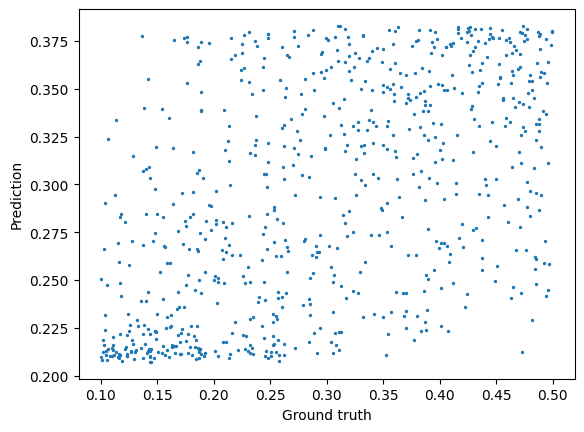

In [29]:
plt.scatter(lbl_cmd, yhat_cmd, s=2)
plt.xlabel('Ground truth')
plt.ylabel('Prediction')

plt.show()